<a href="https://colab.research.google.com/github/Elpastore/WENETAM_VECTOR_GENOMICS_TRAINING_WORKSHOP/blob/main/NewMalaria_Vector_Genomics_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Instructions***

1.) Click on File on the top left corner and select save a copy in drive

Your changes will not be saved if you do not do this step

2.) Click on the name of the workbook in the top left corner and replace "Copy of" with your full name

# **Bioinformatics Pipeline for Malaria Vector Genomics Surveillance**

This notebook demonstrates a complete variant calling pipeline specifically designed for genomic surveillance of malaria vectors and focuses on variant detection in key genomic regions associated with insecticide resistance and other phenotypes relevant to malaria transmission and control.

**Please note, About Our data:**
For today's session, we will be working on 4 paired end Plasmodium Falciparum samples which are generated from illumina sequencing.

## Overview of the Pipeline

1. **Setting up the environment and data**
2. **Quality Control of raw sequencing data** - Critical for accurate variant detection in complex mosquito genomes
3. **Trimming and filtering reads** - Removing adapters and low-quality sequences to improve mapping to Anopheles reference genomes
4. **Alignment to a reference genome** - Mapping reads to the appropriate Anopheles reference genome
5. **Processing and quality control of alignments** - Ensuring high-quality alignments for reliable variant detection
6. **Variant calling** - Identifying SNPs and indels, particularly in genes associated with insecticide resistance
7. **Variant filtering and analysis** - Focusing on key variants related to vector control and transmission dynamics



### Download or prepare Anopheles sample data

One can use publicly available Anopheles genomic data. Common sources include:

1. **VectorBase** (https://vectorbase.org) - Specialized repository for vector genomics
2. **Anopheles gambiae 1000 Genomes Project** - Extensive collection of Anopheles genomic data

Anopheles reference genomes can be obtained from VectorBase, with the most commonly used being:
- *Anopheles gambiae* PEST strain (AgamP4)
- *Anopheles coluzzii* (formerly *An. gambiae* M form)
- *Anopheles arabiensis*

# Data Processing Workflow

In [ ]:
%%html
<img width="50%" height="50%" src="https://vobs-resources.cog.sanger.ac.uk/training/img/workshop-1/w1m2-1.png"/>

Note that raw genome sequence data is not particularly useful by itself, and so the sequence reads are processed through variant-calling pipelines which identify different types of genetic variation between individual mosquitoes.

The results of variant-calling pipelines are then passed through a number of quality control, filtering and annotation steps to ensure data quality. We call this process data curation.

The analysis-ready genome variation data is then made available to all partners in the collaboration. This data can then be analysed to answer questions about the surveillance of mosquito populations, such as whether new forms of insecticide resistance are emerging and spreading.

## 1. **Setting up the environment and data**

First, we'll mount Google Drive to access and store our data.

In [ ]:
#mount your google drive in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2) We will then download our input folder and create a copy of the folder in our google drive.



In [ ]:
#install gdown
!pip install gdown

In [ ]:
#download our work folder for this excercise
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1ZY0z9dGAWKkbrECl7AfwqujSvlRuRrfT?usp=sharing", quiet=True)

['/content/WANETAM_Vector_Workshop/Fastq/MC-023_S318_L001_R1_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-023_S318_L001_R2_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-032_S303_L001_R1_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-032_S303_L001_R2_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-095_S295_L001_R1_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-095_S295_L001_R2_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-096_S315_L001_R1_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Fastq/MC-096_S315_L001_R2_001.fastq.gz',
 '/content/WANETAM_Vector_Workshop/Ref/pf_AmpliconRef.fasta']

In [ ]:
#copy file to onedrive
%cp -r /content/WANETAM_Vector_Workshop /content/drive/MyDrive/WANETAM_Vector_Workshop


In [ ]:
#set path to excercise folder
data_path = '/content/drive/MyDrive/WANETAM_Vector_Workshop'

**Introduction To Basic Linux commands**


In [ ]:
#See current directory
!pwd

/content


In [ ]:
#change directory
%cd $data_path

/content/drive/MyDrive/WANETAM_Vector_Workshop


In [ ]:
#See list of files in our excercise folder
!ls

Fastq  Ref


In [ ]:
#see list of files in fastq folder
!ls Fastq

MC-023_S318_L001_R1_001.fastq.gz  MC-095_S295_L001_R1_001.fastq.gz
MC-023_S318_L001_R2_001.fastq.gz  MC-095_S295_L001_R2_001.fastq.gz
MC-032_S303_L001_R1_001.fastq.gz  MC-096_S315_L001_R1_001.fastq.gz
MC-032_S303_L001_R2_001.fastq.gz  MC-096_S315_L001_R2_001.fastq.gz


In [ ]:
#see the first 10 lines of your fastq file
!zcat Fastq/MC-023_S318_L001_R1_001.fastq.gz|head -n 10

@M05061:119:000000000-KLYPH:1:1101:17282:1001 1:N:0:318
NAATGTTTGAAATGATAAATGAATGGCAGCTTGGC
+
#8CCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
@M05061:119:000000000-KLYPH:1:1101:17734:1002 1:N:0:318
NATGTAATTTTTGTTGTGTATTTATTACAACTTTGCCGGAAGCACCTTCATTTATCATTTCAAACAT
+
#8ABCGGFGGFDGGCFEECFFAFGFGGGGGGC9E9EGE@GGCGAFGG@FGG9FGCCCGGCGGGCFGG
@M05061:119:000000000-KLYPH:1:1101:12529:1004 1:N:0:318
NCGTTAATAATAAATACACGCAGGTAACTATAGTTTTGTAACATCCGGCCCTCCGTTAATAATAAATACACGCAGGTTACAAAACTATAGTTTTGTAACATCCGGGTAACTATAGTTTTGTAACATCCGGGTAACTATAGTTTTGTAAAATCCGAGATCGGAAAAGCACACGTCTGAAAACCAATCACAAAATCGTATCTCGTATGCCATCATCTGCCTGAAAAAAAAAAAAACAACAAACAAAAAAAAC


**Structure of Fastq File**

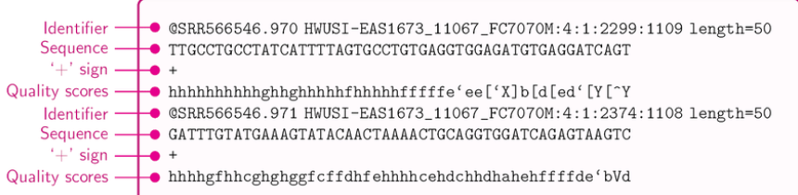

## **2. Quality Control of Raw Sequencing Data**
Quality control (QC) in the context of genomics and bioinformatics refers to the process of assessing and ensuring the quality of raw sequencing data before further analysis.

Quality control steps are essential to identify and address issues or artifacts that can arise during the sequencing process. The goal is to ensure that the data used for downstream analysis is accurate, reliable, and suitable for the intended analysis.

Quality control is particularly important for Anopheles genomics due to:
- The complex nature of mosquito genomes with high repeat content
- The presence of closely related species and subspecies
- The need for high accuracy when identifying insecticide resistance mutations

Let's install and run **FastQC** and **MultiQC** to check the quality of our raw FASTQ files.

In [ ]:
#Install fastqc

!wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip #download
!unzip fastqc_v0.11.9.zip #unzip
!chmod +x FastQC/fastqc #make executable


--2025-05-20 16:39:33--  https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
Resolving www.bioinformatics.babraham.ac.uk (www.bioinformatics.babraham.ac.uk)... 149.155.133.4
Connecting to www.bioinformatics.babraham.ac.uk (www.bioinformatics.babraham.ac.uk)|149.155.133.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10249221 (9.8M) [application/zip]
Saving to: ‘fastqc_v0.11.9.zip’

fastqc_v0.11.9.zip  100%[===================>]   9.77M  11.8MB/s    in 0.8s    

2025-05-20 16:39:34 (11.8 MB/s) - ‘fastqc_v0.11.9.zip’ saved [10249221/10249221]

Archive:  fastqc_v0.11.9.zip
  inflating: FastQC/cisd-jhdf5.jar   
   creating: FastQC/Configuration/
  inflating: FastQC/Configuration/adapter_list.txt  
  inflating: FastQC/Configuration/contaminant_list.txt  
  inflating: FastQC/Configuration/limits.txt  
  inflating: FastQC/fastqc           
  inflating: FastQC/fastqc_icon.ico  
   creating: FastQC/Help/
   creating: FastQC/Help/1 Introductio

In [ ]:
#Create directory
!mkdir fastqcOutput

In [ ]:
#Run fastqc on multiple fastq files
!FastQC/fastqc Fastq/* -o fastqcOutput

Started analysis of MC-023_S318_L001_R1_001.fastq.gz
Approx 5% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 10% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 15% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 20% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 25% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 30% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 35% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 40% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 45% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 50% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 55% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 60% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 65% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 70% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 75% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 80% complete for MC-023_S318_L001_R1_001.fastq.gz
Approx 85% complete for MC-023_S318_

Lets review one of the fastqc html files!

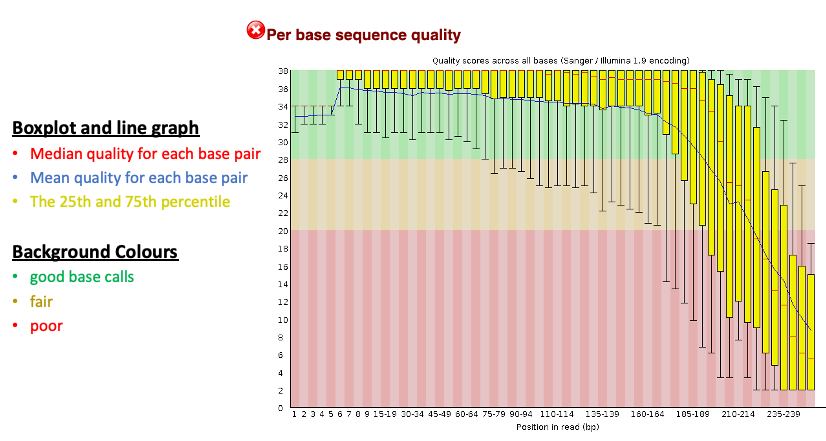

In [ ]:
#Install multiqc
!pip install multiqc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
#Run multiqc on fastqc results
!mkdir -p multiqcOutput
!multiqc /content/MyDrive/WANETAM_Vector_Workshop/fastqcOutput -o /content/MyDrive/WANETAM_Vector_Workshop/multiqcOutput

                                                                                
 /// ]8;id=764060;https://multiqc.info\MultiQC]8;;\ 🔍 v1.28                                                           
                                                                                
 Usage: multiqc [OPTIONS] [ANALYSIS DIRECTORY]                                  
                                                                                
 This is MultiQC v1.28                                                          
 For more help, run 'multiqc --help' or visit ]8;id=522109;http://multiqc.info\http://multiqc.info]8;;\               
╭─ Error ──────────────────────────────────────────────────────────────────────╮
│ Invalid value for '[ANALYSIS DIRECTORY]': Path                               │
│ '/content/MyDrive/WANETAM_Vector_Workshop/fastqcOutput' does not exist.      │
╰──────────────────────────────────────────────────────────────────────────────╯
                         

### Interpreting FastQC/MultiQC Results

When examining FastQC results, pay special attention to:

1. **Per base sequence quality** - Should be high throughout most of the read. Poor quality at read ends is common and should be trimmed.
2. **Per sequence quality scores** - Should show a peak at high quality. Multiple peaks may indicate mixed sample quality.
3. **Adapter content** - Should be minimal or absent. Anopheles samples often show Illumina adapter contamination that must be removed.
4. **Overrepresented sequences** - Could indicate adapter contamination or PCR artifacts from amplicon sequencing of resistance genes.
5. **Per base sequence content** - Should show roughly equal proportions of bases. Significant deviation may indicate sequencing bias in AT-rich regions common in mosquito genomes.
6. **Sequence duplication levels** - High duplication can indicate PCR bias or overamplification of certain genomic regions.

Based on these results, we'll determine the optimal trimming parameters for Anopheles data in the next step.

## **3. Trimming and Filtering Reads**
Trimming can be performed using various tools and software packages, such as **Trimmomatic**, **Cutadapt**, **Fastp**, **Trim Galore**, **Skewer**, etc.

The specific trimming steps and parameters used depend on the quality of the data, the library preparation method, the sequencing platform, and the downstream analysis goals.

***Overall, trimming helps to ensure that the sequenced data used in downstream analyses are of high quality, accurate, and reliable, leading to more meaningful and reproducible results.***

### Importance of Trimming for Anopheles Genomics

Trimming is especially crucial for Anopheles genomic analysis because:
- It improves mapping to repetitive regions in mosquito genomes
- It reduces false positives when calling variants in insecticide resistance genes
- It helps in distinguishing between closely related Anopheles species
- It removes sequencing artifacts that can interfere with population genetic analyses

For this tutorial, We will be using [***Fastp***](https://academic.oup.com/bioinformatics/article/34/17/i884/5093234).

**Slidingwindow:-** removes low quality ends of reads. It involves moving a fixed-size window (often a small number of bases) along the length of a read. At each position of the window, the average quality score of the bases within the window is calculated. A threshold quality score is set as a criterion. If the average quality score within the window falls below this threshold, it indicates a region of low-quality bases and therefore trimmed off.



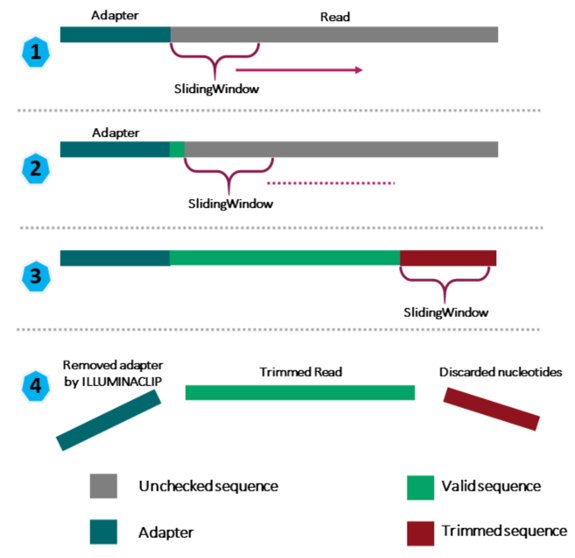

In [ ]:
#Install fastp
!wget http://opengene.org/fastp/fastp
!chmod a+x fastp

--2025-05-20 16:45:17--  http://opengene.org/fastp/fastp
Resolving opengene.org (opengene.org)... 8.210.133.117
Connecting to opengene.org (opengene.org)|8.210.133.117|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://opengene.org/fastp/fastp [following]
--2025-05-20 16:45:17--  https://opengene.org/fastp/fastp
Connecting to opengene.org (opengene.org)|8.210.133.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9528432 (9.1M) [application/octet-stream]
Saving to: ‘fastp’

fastp               100%[===================>]   9.09M  4.03MB/s    in 2.3s    

2025-05-20 16:45:20 (4.03 MB/s) - ‘fastp’ saved [9528432/9528432]



In [ ]:
#Check version fastp version installed
!./fastp --version

fastp 0.24.0


In [ ]:
# fastp help command
!./fastp --help

usage: ./fastp [options] ... 
options:
  -i, --in1                            read1 input file name (string [=])
  -o, --out1                           read1 output file name (string [=])
  -I, --in2                            read2 input file name (string [=])
  -O, --out2                           read2 output file name (string [=])
      --unpaired1                      for PE input, if read1 passed QC but read2 not, it will be written to unpaired1. Default is to discard it. (string [=])
      --unpaired2                      for PE input, if read2 passed QC but read1 not, it will be written to unpaired2. If --unpaired2 is same as --unpaired1 (default mode), both unpaired reads will be written to this same file. (string [=])
      --overlapped_out                 for each read pair, output the overlapped region if it has no any mismatched base. (string [=])
      --failed_out                     specify the file to store reads that cannot pass the filters. (string [=])
  -m, --merge

In [ ]:
#Create a fastp trimmed directory
!mkdir fastp_trimmed

In [ ]:
#Run fastp command for a single paired-end read
# fastp command that removes: TruSeq Adapter --adapter_truseq

!./fastp \
--in1 Fastq/MC-023_S318_L001_R1_001.fastq.gz \
--in2 Fastq/MC-023_S318_L001_R2_001.fastq.gz \
--out1 fastp_trimmed/MC-023_S318_L001_paired_R1_001.fastq.gz \
--out2 fastp_trimmed/MC-023_S318_L001_paired_R2_001.fastq.gz \
--detect_adapter_for_pe \
--html fastp_trimmed/fastp_report.html \
--json fastp_trimmed/fastp_report.json \
--trim_poly_g \
--trim_poly_x \
--cut_tail \
--length_required 50 \
--correction \
--max_len1 150 \
--max_len2 150 \
--overrepresentation_analysis

Detecting adapter sequence for read1...
No adapter detected for read1

Detecting adapter sequence for read2...
No adapter detected for read2

Read1 before filtering:
total reads: 879972
total bases: 80640510
Q20 bases: 72997352(90.5219%)
Q30 bases: 67181616(83.31%)

Read2 before filtering:
total reads: 879972
total bases: 82120534
Q20 bases: 69378454(84.4837%)
Q30 bases: 61440126(74.817%)

Read1 after filtering:
total reads: 756094
total bases: 63385765
Q20 bases: 61682787(97.3133%)
Q30 bases: 58997171(93.0764%)

Read2 after filtering:
total reads: 756094
total bases: 61863535
Q20 bases: 58929656(95.2575%)
Q30 bases: 54641667(88.3261%)

Filtering result:
reads passed filter: 1512188
reads failed due to low quality: 34334
reads failed due to too many N: 194
reads failed due to too short: 213228
reads with adapter trimmed: 111710
bases trimmed due to adapters: 9089650
reads with polyX in 3' end: 12046
bases trimmed in polyX tail: 174196
reads corrected by overlap analysis: 227888
bases c

### fastp Parameters for Anopheles Sequence Data

fastp offers several parameters particularly useful for Anopheles sequencing data:

1. **Basic Parameters**
   - `--in1/--in2`: Input paired-end FASTQ files
   - `--out1/--out2`: Output trimmed paired-end files
   - `--html/--json`: Report outputs

2. **Quality Control**
   - `--qualified_quality_phred`: The minimum quality value to keep (default 15)
   - `--unqualified_percent_limit`: Percentage of bases allowed to be unqualified (default 40)
   - For Anopheles data, increasing this to 20 can improve specificity in mapping

3. **Trimming Options**
   - `--trim_front1/--trim_front2`: Trim bases from read start (useful for removing primer sequences)
   - `--trim_tail1/--trim_tail2`: Trim bases from read end
   - `--max_len1/--max_len2`: Maximum read length (helps standardize read lengths)

4. **Adapter Processing**
   - `--detect_adapter_for_pe`: Automatically detect and remove adapters for paired-end data

5. **Duplication and Correction**
   - `--correction`: Enable base correction for overlapped regions
   - `--dedup`: Remove duplicated reads (use cautiously as it may affect allele frequency)

When using trimmed reads for alignment, you typically use the paired-end files that passed the trimming process. These are the files containing reads where both pairs have survived the quality filtering and trimming steps. In our case, these are stored in the folder called "fastp_trimmed".

**Working with multiple files**

When working with multiple files, it is preferable to run these processes in **parallel** or use a **loop**. Running parallel programs can be memory-intensive hence requires the use of a HPC and loops requires small amount of memory hence making it suitable for personal computers.

We will be using loops in our excercises for this training.


**What is a Loop?**

A loop is a fundamental concept in programming. It's a way to repeat a set of instructions multiple times. Imagine if you had to write the same line of code over and over again - it would be time-consuming and prone to errors. A loop helps automate this process.




In [ ]:
%cd /content/drive/MyDrive/WANETAM_Vector_Workshop/
!pwd

/content/drive/MyDrive/WANETAM_Vector_Workshop
/content/drive/MyDrive/WANETAM_Vector_Workshop


In [ ]:
import os
import glob

# Specify the pattern you want to match
pattern = '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/*'  # This example matches all .R1_001.fastq.gz files

# Get a list of files matching the pattern
file_list = glob.glob(pattern)
print(file_list)

['/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-023_S318_L001_R1_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-023_S318_L001_R2_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-032_S303_L001_R1_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-032_S303_L001_R2_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-095_S295_L001_R1_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-095_S295_L001_R2_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-096_S315_L001_R1_001.fastq.gz', '/content/drive/MyDrive/WANETAM_Vector_Workshop/Fastq/MC-096_S315_L001_R2_001.fastq.gz']


In [ ]:
import os
import glob

# Specify the pattern you want to match
pattern = 'Fastq/*R1_001.fastq.gz'  # This example matches all .R1_001.fastq.gz files in the Fastq directory
# Get a list of files matching the pattern
file_list = glob.glob(pattern)

!mkdir -p fastp_trimmed

for infile in file_list:
    base = os.path.basename(infile)
    # Assuming the file names follow the pattern BaseName_R1_001.fastq.gz
    base = base.replace('_R1_001.fastq.gz', '')

    input_forward = f'Fastq/{base}_R1_001.fastq.gz'
    input_reverse = f'Fastq/{base}_R2_001.fastq.gz'
    output_forward_paired = f'fastp_trimmed/{base}_paired_R1_001.fastq.gz'
    output_reverse_paired = f'fastp_trimmed/{base}_paired_R2_001.fastq.gz'
    output_html_report = f'fastp_trimmed/{base}_fastp_report.html'
    output_json_report = f'fastp_trimmed/{base}_fastp_report.json'


    print(f'Processing {base}')

!./fastp \
--in1 {input_forward} \
--in2 {input_reverse} \
--out1 {output_forward_paired} \
--out2 {output_reverse_paired} \
--detect_adapter_for_pe \
--html {output_html_report} \
--json {output_json_report} \
--trim_poly_g \
--trim_poly_x \
--cut_tail \
--length_required 50 \
--correction

mkdir: cannot create directory ‘fastp_trimmed’: File exists
Processing MC-023_S318_L001
Processing MC-032_S303_L001
Processing MC-095_S295_L001
Processing MC-096_S315_L001
Detecting adapter sequence for read1...
No adapter detected for read1

Detecting adapter sequence for read2...
No adapter detected for read2

Read1 before filtering:
total reads: 422168
total bases: 54366249
Q20 bases: 47398023(87.1828%)
Q30 bases: 41794919(76.8766%)

Read2 before filtering:
total reads: 422168
total bases: 56872392
Q20 bases: 43188296(75.9389%)
Q30 bases: 35303667(62.0752%)

Read1 after filtering:
total reads: 368783
total bases: 42577780
Q20 bases: 39774966(93.4172%)
Q30 bases: 36518596(85.7691%)

Read2 after filtering:
total reads: 368783
total bases: 40850036
Q20 bases: 36295543(88.8507%)
Q30 bases: 31683594(77.5607%)

Filtering result:
reads passed filter: 737566
reads failed due to low quality: 36106
reads failed due to too many N: 136
reads failed due to too short: 70528
reads with adapter tri

In [ ]:
!ls fastp_trimmed/

fastp_report.html
fastp_report.json
MC-023_S318_L001_paired_R1_001.fastq.gz
MC-023_S318_L001_paired_R2_001.fastq.gz
MC-096_S315_L001_fastp_report.html
MC-096_S315_L001_fastp_report.json
MC-096_S315_L001_paired_R1_001.fastq.gz
MC-096_S315_L001_paired_R2_001.fastq.gz


In [ ]:
#Run multiqc for trimmed reads
!multiqc fastp_trimmed/ -o fastp_trimmed/multiqc_report


/// ]8;id=113794;https://multiqc.info\MultiQC]8;;\ 🔍 v1.28

       file_search | Search path: /content/drive/MyDrive/WANETAM_Vector_Workshop/fastp_trimmed
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 8/8  
             fastp | Found 2 reports
     write_results | Data        : fastp_trimmed/multiqc_report/multiqc_data
     write_results | Report      : fastp_trimmed/multiqc_report/multiqc_report.html
           multiqc | MultiQC complete


## **4. Alignment of Filtered Reads**

---
![image.png](https://training.galaxyproject.org/training-material/topics/sequence-analysis/images/mapping/mapping.png)


Alignment is the process of mapping sequencing reads (short DNA or RNA fragments) to a reference genome or a similar reference sequence. The alignment process is a fundamental step in analyzing raw sequencing data to understand genetic variation, gene expression, and other biological phenomena. In bioinformatics, we have several alignment tools which include **BWA, BOWTIE, STAR, NOVO ALIGN, etc.**

In [ ]:
#Install BWA
!apt-get install bwa

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  samtools
The following NEW packages will be installed:
  bwa
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 195 kB of archives.
After this operation, 466 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 bwa amd64 0.7.17-6 [195 kB]
Fetched 195 kB in 0s (1,174 kB/s)
Selecting previously unselected package bwa.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../bwa_0.7.17-6_amd64.deb ...
Unpacking bwa (0.7.17-6) ...
Setting up bwa (0.7.17-6) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
#Index reference genome before alignment
!bwa index Ref/pf_AmpliconRef.fasta

# Define reference genome variable for easier updates
#REFERENCE_GENOME = "Ref/pf_AmpliconRef.fasta"

# Index the reference genome
#!bwa index $REFERENCE_GENOME

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index Ref/pf_AmpliconRef.fasta
[main] Real time: 0.089 sec; CPU: 0.010 sec


In [ ]:
#Create output directory
!mkdir -p bamFiles

Run the code below to align one of the raw fastq files to the reference genome.

In [ ]:
#Alignment
!bwa mem -t 10 -M -R "@RG\tID:MC-023_S318_L001_FLOWCELL1.LANE1\tPL:ILLUMINA\tLB:MC-023_S318_L001\tSM:MC-023_S318_L001" Ref/pf_AmpliconRef.fasta \
fastp_trimmed/MC-023_S318_L001_paired_R1_001.fastq.gz fastp_trimmed/MC-023_S318_L001_paired_R2_001.fastq.gz > bamFiles/MC-023_S318_L001_paired.sam


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 1207354 sequences (100000055 bp)...
[M::process] read 304834 sequences (25249245 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (14, 576905, 1558, 11)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (2, 8, 523)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1565)
[M::mem_pestat] mean and std.dev: (244.93, 280.95)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 2086)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (30, 33, 36)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (18, 48)
[M::mem_pestat] mean and std.dev: (31.48, 4.65)
[M::mem_pestat] low and high boundaries for proper pairs: (12, 54)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentil

### Understanding BWA Parameters for Anopheles Genomics

- **-t 8** - Use 8 threads for faster processing
  - Adjust based on available compute resources
  
- **-M** - Mark shorter split hits as secondary
  - Important for Anopheles due to high repeat content and gene family duplications
  - Ensures compatibility with downstream tools like GATK and Picard
  
- **-R** - Add read group information, which is critical for variant calling
  - **ID**: Read group identifier (unique identifier per sequencing run)
  - **SM**: Sample name (crucial for distinguishing different Anopheles specimens)
  - **PL**: Platform (ILLUMINA, OXFORD_NANOPORE, etc.)
  - **LB**: Library identifier
  
- **Additional Parameters for Anopheles Studies**:
  - **-A**: Score for a sequence match (default: 1)
  - **-B**: Penalty for a mismatch (default: 4)
  - **-O**: Gap open penalty (default: 6)
  - **-E**: Gap extension penalty (default: 1)

**Note:**
Remember to adapt the command to your specific data and reference genome. Always consult the documentation and best practices for the tools you're using to ensure accurate and reliable results.






[SAMtools](https://samtools.sourceforge.net/) is a powerful suite of utilities for interacting with and manipulating files in the Sequence Alignment/Map (SAM) and Binary Alignment/Map (BAM) formats, which are common file formats used in genomics. It provides a wide range of functionalities for processing and analyzing high-throughput sequencing data, making it an essential tool for bioinformaticians and genomics researchers.

In [ ]:
#install samtools
!apt-get install samtools

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libhts3 libhtscodecs2
Suggested packages:
  cwltool
The following NEW packages will be installed:
  libhts3 libhtscodecs2 samtools
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 963 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhtscodecs2 amd64 1.1.1-3 [53.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhts3 amd64 1.13+ds-2build1 [390 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 samtools amd64 1.13-4 [520 kB]
Fetched 963 kB in 1s (1,252 kB/s)
Selecting previously unselected package libhtscodecs2:amd64.
(Reading database ... 126119 files and directories currently installed.)
Preparing to unpack .../libhtscodecs2_1.1.1-3_amd64.deb ...
Unpacking libhtscodecs2:amd64 (1.1.

In [ ]:
#Check coverage of bam file before filteration
!samtools flagstat bamFiles/MC-023_S318_L001_paired.sam

1951173 + 0 in total (QC-passed reads + QC-failed reads)
1512188 + 0 primary
438985 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
1914803 + 0 mapped (98.14% : N/A)
1475818 + 0 primary mapped (97.59% : N/A)
1512188 + 0 paired in sequencing
756094 + 0 read1
756094 + 0 read2
1453384 + 0 properly paired (96.11% : N/A)
1470436 + 0 with itself and mate mapped
5382 + 0 singletons (0.36% : N/A)
160 + 0 with mate mapped to a different chr
160 + 0 with mate mapped to a different chr (mapQ>=5)


In [ ]:
#Convert sam to bam and remove unmapped reads
!samtools view -@ 10 -bh -F 4 bamFiles/MC-023_S318_L001_paired.sam -o bamFiles/MC-023_S318_L001_paired.bam

In [ ]:
#Check coverage of bam file after filteration
!samtools flagstat bamFiles/MC-023_S318_L001_paired.bam

1914803 + 0 in total (QC-passed reads + QC-failed reads)
1475818 + 0 primary
438985 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
1914803 + 0 mapped (100.00% : N/A)
1475818 + 0 primary mapped (100.00% : N/A)
1475818 + 0 paired in sequencing
738596 + 0 read1
737222 + 0 read2
1453384 + 0 properly paired (98.48% : N/A)
1470436 + 0 with itself and mate mapped
5382 + 0 singletons (0.36% : N/A)
160 + 0 with mate mapped to a different chr
160 + 0 with mate mapped to a different chr (mapQ>=5)


In [ ]:
#sort bam file
!samtools sort  -@ 10 -o bamFiles/MC-023_S318_L001_pairedSorted.bam bamFiles/MC-023_S318_L001_paired.bam

[bam_sort_core] merging from 0 files and 10 in-memory blocks...


In [ ]:
#Index bam file
!samtools index bamFiles/MC-023_S318_L001_pairedSorted.bam

In [ ]:
#See header of bam file
!samtools view -H bamFiles/MC-023_S318_L001_pairedSorted.bam

@HD	VN:1.6	SO:coordinate
@SQ	SN:PF3D7_0417200	LN:2169
@SQ	SN:PF3D7_0709000	LN:3957
@SQ	SN:PF3D7_0810800	LN:3162
@SQ	SN:PF3D7_1224000	LN:1872
@RG	ID:MC-023_S318_L001_FLOWCELL1.LANE1	PL:ILLUMINA	LB:MC-023_S318_L001	SM:MC-023_S318_L001
@PG	ID:bwa	PN:bwa	VN:0.7.17-r1188	CL:bwa mem -t 10 -M -R @RG\tID:MC-023_S318_L001_FLOWCELL1.LANE1\tPL:ILLUMINA\tLB:MC-023_S318_L001\tSM:MC-023_S318_L001 Ref/pf_AmpliconRef.fasta fastp_trimmed/MC-023_S318_L001_paired_R1_001.fastq.gz fastp_trimmed/MC-023_S318_L001_paired_R2_001.fastq.gz
@PG	ID:samtools	PN:samtools	PP:bwa	VN:1.13	CL:samtools view -@ 10 -bh -F 4 -o bamFiles/MC-023_S318_L001_paired.bam bamFiles/MC-023_S318_L001_paired.sam
@PG	ID:samtools.1	PN:samtools	PP:samtools	VN:1.13	CL:samtools sort -@ 10 -o bamFiles/MC-023_S318_L001_pairedSorted.bam bamFiles/MC-023_S318_L001_paired.bam
@PG	ID:samtools.2	PN:samtools	PP:samtools.1	VN:1.13	CL:samtools view -H bamFiles/MC-023_S318_L001_pairedSorted.bam


In [ ]:
#See few lines from bam file
!samtools view bamFiles/MC-023_S318_L001_pairedSorted.bam|head -n 10

M05061:119:000000000-KLYPH:1:1104:13787:4932	419	PF3D7_0417200	296	60	71H30M42H	=	745	491	CACATTTAGAGGTCTAGGAAATAAAGGAGT	FGGGGGGGGAAFGGGGGGGGGGDGFGGGGG	NM:i:0	MD:Z:30	MC:Z:101H42M	AS:i:30	XS:i:0	RG:Z:MC-023_S318_L001_FLOWCELL1.LANE1	SA:Z:PF3D7_0417200,745,+,101S42M,60,0;PF3D7_0810800,2339,-,110S33M,60,0;PF3D7_0810800,1730,-,71S31M41S,60,0;
M05061:119:000000000-KLYPH:1:1104:13787:4932	339	PF3D7_0417200	296	60	71H30M42H	=	745	421	CACATTTAGAGGTCTAGGAAATAAAGGAGT	GGGGGGGGF8GGGGGGGGGGGGGGGGGGGG	NM:i:0	MD:Z:30	MC:Z:101H42M	AS:i:30	XS:i:0	RG:Z:MC-023_S318_L001_FLOWCELL1.LANE1	SA:Z:PF3D7_0417200,745,-,101S42M,60,0;PF3D7_0810800,2339,+,110S33M,60,0;PF3D7_0810800,1730,+,71S31M41S,60,0;
M05061:119:000000000-KLYPH:1:1101:20989:2152	355	PF3D7_0417200	297	60	30M34H	=	751	490	ACATTTAGAGGTCTAGGAAATAAAGGAGTA	-ABCCFCFG<CFFD@FC@EEG@FGGF8C6C	NM:i:0	MD:Z:30	MC:Z:28H36M	AS:i:30	XS:i:0	RG:Z:MC-023_S318_L001_FLOWCELL1.LANE1	SA:Z:PF3D7_0417200,751,+,28S36M,60,0;
M05061:119:000000000-KLYPH:1:1101:8698:3239	97	PF

### Understanding Samtools Parameters

- **samtools view**:
  - **-b**: Output in BAM format
  - **-S**: Input is SAM format
  - **-F 4**: Filter out unmapped reads (useful for removing reads from contaminating organisms)
  - **-q 20**: Filter by mapping quality (particularly important for Anopheles species complexes)
  
- **samtools sort**:
  - **-@ 8**: Use 8 threads
  - Sorted BAMs are essential for all downstream analyses
  
- **samtools index**:
  - Creates an index allowing random access to the BAM file
  - Necessary for viewing alignments in specific regions (e.g., insecticide resistance loci)
  
- **samtools flagstat**:
  - Provides mapping statistics
  - For Anopheles data, expect mapping rates of >85% for good quality samples to the correct reference
  
- **samtools markdup**:
  - Identifies PCR duplicates
  - Critical for accurate allele frequency estimation in population genomics
  - For amplicon sequencing of insecticide resistance genes, assess duplication rates carefully

Structure of a ***bam*** file.

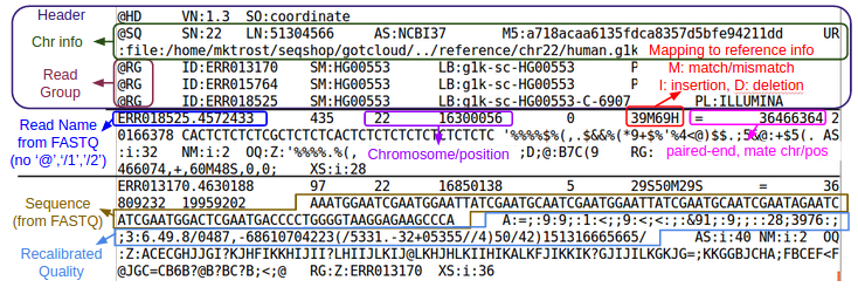

Now that we have completed the alignment process for one of the samples, let's use the following command to **loop** through the list of samples from the trimmed output we obtained.

In [ ]:
import os
import glob

# Specify the pattern you want to match
pattern = '/content/drive/MyDrive/WANETAM_Vector_Workshop/fastp_trimmed/*R1_001.fastq.gz'  # This example matches all .R1_001.fastq.gz files

# Get a list of files matching the pattern
file_list = glob.glob(pattern)
!mkdir -p bamFiles

for infile in file_list:
    base = os.path.basename(infile)
    base = base.replace('_R1_001.fastq.gz', '')
    print(base)

    #Alignment
    !bwa mem -t 10 -M -R "@RG\tID:{base}_FLOWCELL1.LANE1\tPL:ILLUMINA\tLB:{base}\tSM:{base}" Ref/pf_AmpliconRef.fasta \
    fastp_trimmed/{base}_R1_001.fastq.gz fastp_trimmed/{base}_R2_001.fastq.gz > bamFiles/{base}.sam

    #install samtools
    !apt-get install samtools

    #Convert sam to bam and remove unmapped reads
    !samtools view -@ 10 -bh -F 4 bamFiles/{base}.sam -o bamFiles/{base}.bam

    #sort bam file
    !samtools sort  -@ 10 -o bamFiles/{base}_Sorted.bam bamFiles/{base}.bam

    #Index bam file
    !samtools index bamFiles/{base}_Sorted.bam

    #Remove preprocessed files
    !rm bamFiles/*.sam bamFiles/{base}.bam

MC-023_S318_L001_paired
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 1207354 sequences (100000055 bp)...
[M::process] read 304834 sequences (25249245 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (14, 576905, 1558, 11)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (2, 8, 523)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1565)
[M::mem_pestat] mean and std.dev: (244.93, 280.95)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 2086)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (30, 33, 36)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (18, 48)
[M::mem_pestat] mean and std.dev: (31.48, 4.65)
[M::mem_pestat] low and high boundaries for proper pairs: (12, 54)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat

### Examine Alignment Statistics

Let's check the alignment quality for one of our samples. For Anopheles data, here's what to look for:

1. **Mapping rate**: Should be >85% to the correct reference species
2. **Properly paired reads**: Should be >80% for good quality data
3. **Duplication rate**: Should be <20% unless using amplicon sequencing
4. **Coverage uniformity**: Important for detecting structural variants

You can check the coverage of your reads using tools like **samtools**, **Qualimap**, **AGV**, etc

Lets use samtools to see the quality of our Bam files.

## **5. Variant Calling**

This is a pivotal step in identifying genetic variations or mutations within DNA sequences, particularly from high-throughput sequencing data stored in BAM files. Several variant calling tools are available, each with its own strengths and considerations.

For Illumina data, some popular variant calling tools include [GATK](https://www.broadins=tute.org/gatk/index.php) (Genome Analysis Toolkit), [Freebayes](https://github.com/ekg/freebayes), and [bcftools](https://samtools.github.io/bcftools/bcftools.html), among others. When deciding on a variant calling tool, it's crucial to strike a balance between accuracy and processing speed, as these tools exhibit variances in performance.

**GATK**, short for Genome Analysis Toolkit, is renowned for its precision and versatility. It is often the tool of choice for whole genome sequences, as it delivers highly accurate variant calls. Furthermore, it offers a range of additional features, such as base quality score recalibration and variant quality score recalibration, which enhance its ability to detect true variants while minimizing false positives. While GATK excels in accuracy, it's also relatively efficient in terms of processing speed.

**Freebayes**, on the other hand, is another reliable variant caller known for its accuracy. However, it typically operates at a slower pace compared to GATK. Therefore, it is less favored for whole genome sequencing but finds its niche in calling variants from amplicon sequences or smaller datasets where speed is not a primary concern.

**Bcftools**, by contrast, is the fastest among these three tools but may trade off some accuracy for speed. It's an efficient choice for projects where rapid processing is essential, such as when dealing with large-scale datasets. However, users should be aware of its limitations in terms of accuracy and may need to employ additional filtering and validation steps.

In conclusion, the choice of a variant calling tool should align with the nature of the data and the specific requirements of the project. Understanding the strengths and limitations of each tool is essential in making an informed decision for variant calling in genomics research.


Now we'll identify genomic variants (SNPs and indels) using **FreeBayes**, a Bayesian variant caller. For malaria vector surveillance, we'll focus on identifying variants associated with:

1. Insecticide resistance
2. Species differentiation
3. Population structure
4. Adaptive traits affecting vectorial capacity

FreeBayes is well-suited for Anopheles variant calling because it:
- Handles polyploid samples (useful for pooled sequencing of field collections)
- Performs well on both low and high-coverage data
- Can detect complex haplotypes around resistance mutations
- Considers non-reference sites with sufficient evidence


In [ ]:
#Install freebayes
!apt-get install freebayes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdisorder0 libfastahack0 libfml0 libseqlib2 libsmithwaterman0 libssw0
  libtabixpp0 libvcflib1 parallel sysstat
Suggested packages:
  ash csh fish ksh tcsh zsh isag
The following NEW packages will be installed:
  freebayes libdisorder0 libfastahack0 libfml0 libseqlib2 libsmithwaterman0
  libssw0 libtabixpp0 libvcflib1 parallel sysstat
0 upgraded, 11 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,437 kB of archives.
After this operation, 8,967 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libfml0 amd64 0.1+git20190320.b499514-1 [70.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libssw0 amd64 1.1-13 [19.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libseqlib2 amd64 1.2.0+dfsg-8build1 [175 kB]
Get:4 http://archive.ubuntu.com/ub

In [ ]:
#Check version of freebayes
!freebayes --version


version:  v1.3.6


In [ ]:
#show freebayes help info
!freebayes -h


usage: freebayes -f [REFERENCE] [OPTIONS] [BAM FILES] >[OUTPUT]

Bayesian haplotype-based polymorphism discovery.

parameters:

   -h --help       For a complete description of options.

freebayes is maintained by Erik Garrison and Pjotr Prins.

citation: Erik Garrison, Gabor Marth
          "Haplotype-based variant detection from short-read sequencing"
          arXiv:1207.3907 (http://arxiv.org/abs/1207.3907)

author:   Erik Garrison <erik.garrison@gmail.com>
version:  v1.3.6

overview:

    To call variants from aligned short-read sequencing data, supply BAM files and
    a reference.  FreeBayes will provide VCF output on standard out describing SNPs,
    indels, and complex variants in samples in the input alignments.

    By default, FreeBayes will consider variants supported by at least 2
    observations in a single sample (-C) and also by at least 20% of the reads from
    a single sample (-F).  These settings are suitable to low to high depth
    sequencing in haploid and dipl

One of the beauties of **Freebayes** is that it allows us to do variant calling on multiple bam files and gives one vcf output that contains results for multiple samples.

In [ ]:
#list bam files and save in file
!ls bamFiles/*.bam > bamFiles.list
#create directory
!mkdir -p vcfOutput

In [ ]:
#Call variants with freebayes from your aligned reads
!freebayes -p 2 -m 20 -q 20 -F 0.05 --min-coverage 5 -f Ref/pf_AmpliconRef.fasta -L bamFiles.list > vcfOutput/freebayesOutput.vcf


index file Ref/pf_AmpliconRef.fasta.fai not found, generating...


### Understanding FreeBayes Parameters for Anopheles Studies

- **-f** - Reference genome in FASTA format
  - Use the most appropriate Anopheles reference for your samples

- **-p 2** - Ploidy (2 for diploid organisms)
  - Use 2 for diploid calling in individual mosquitoes
  - For pooled samples, set to the estimated number of individuals in the pool (e.g., `-p 20`)
  - Use `--pooled-discrete` for proper handling of pooled samples

- **-m 20** - Minimum mapping quality for an alignment to be used
  - Higher values (20-30) reduce artifacts from misalignments in repetitive regions
  - Particularly important for paralogous genes in Anopheles
  
- **-q 20** - Minimum base quality for a base to be used
  - Higher values reduce noise from sequencing errors
  - Critical for accurate detection of resistance mutations
  
- **-F 0.05** - Minimum fraction of alternate observations
  - Default (0.05) works for individual samples
  - For pooled samples or to detect minor resistance alleles, lower to 0.01
  - For adaptive sweep detection, higher settings may be appropriate
  
- **--min-coverage 5** - Minimum coverage required to call a variant
  - Increase for resistance loci (10-20x) to ensure accurate genotyping
  - Population studies typically use higher thresholds (10-30x)
  
- **-L** - List of BAM files to analyze
  - For population studies, include multiple samples for joint calling
  
- **-t** - BED file with target regions
  - Useful for focusing on insecticide resistance loci
  - Speeds up analysis and reduces computational requirements
  
- **Additional Parameters for Anopheles Studies**:
  - **--haplotype-length 0**: Set to >0 to detect complex haplotypes (useful for resistance loci)
  - **--use-best-n-alleles 4**: Limit the number of alternate alleles to consider (helpful for complex regions)
  - **--min-alternate-count 2**: Require at least 2 observations of an alternate allele

**View vcf files**

Several tools can be used to view the conent of your vcf file but the most commonly used is bcftools.

In [ ]:
#Download bctools
!apt-get install -y bcftools

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  python3-numpy python3-matplotlib texlive-latex-recommended
The following NEW packages will be installed:
  bcftools
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 697 kB of archives.
After this operation, 2,360 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 bcftools amd64 1.13-1 [697 kB]
Fetched 697 kB in 0s (5,664 kB/s)
Selecting previously unselected package bcftools.
(Reading database ... 126470 files and directories currently installed.)
Preparing to unpack .../bcftools_1.13-1_amd64.deb ...
Unpacking bcftools (1.13-1) ...
Setting up bcftools (1.13-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
#vcf header
!bcftools view vcfOutput/freebayesOutput.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##fileDate=20250520
##source=freeBayes v1.3.6
##reference=Ref/pf_AmpliconRef.fasta
##contig=<ID=PF3D7_0417200,length=2169>
##contig=<ID=PF3D7_0709000,length=3957>
##contig=<ID=PF3D7_0810800,length=3162>
##contig=<ID=PF3D7_1224000,length=1872>
##phasing=none
##commandline="freebayes -p 2 -m 20 -q 20 -F 0.05 --min-coverage 5 -f Ref/pf_AmpliconRef.fasta -L bamFiles.list"
##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of samples with data">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total read depth at the locus">
##INFO=<ID=DPB,Number=1,Type=Float,Description="Total read depth per bp at the locus; bases in reads overlapping / bases in haplotype">
##INFO=<ID=AC,Number=A,Type=Integer,Description="Total number of alternate alleles in called genotypes">
##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles in called genotypes">
##INFO=<ID=AF,Number=A,Type=Float,Description="Estimated all

## Understanding VCF File Structure
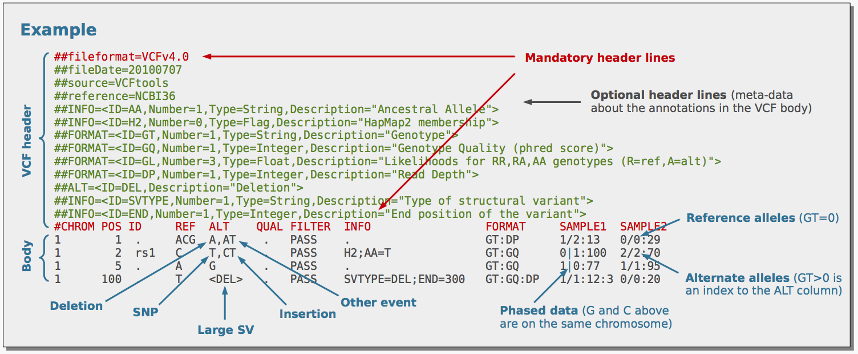

A VCF file contains:
1. **Header** - Lines starting with ## that describe the file format and fields
2. **Column Header** - A line starting with # that names the columns
3. **Variant Records** - One line per variant with fields like:
   - CHROM - Chromosome/contig name
   - POS - 1-based position
   - ID - Variant identifier (often '.')
   - REF - Reference allele
   - ALT - Alternate allele(s)
   - QUAL - Quality score
   - FILTER - Filter status ('PASS' or filter name)
   - INFO - Additional annotations
   - FORMAT - Format of sample genotypes
   - Sample columns - Genotype data for each sample

For Anopheles malaria vectors, key formats include:
- **GT**: Genotype (0/0, 0/1, 1/1, etc.)
- **DP**: Read depth at position
- **AD**: Allelic depths (ref,alt1,alt2...)
- **GQ**: Genotype quality
- **PL**: Phred-scaled genotype likelihoods

These fields help determine if a mosquito carries resistance mutations in heterozygous or homozygous form.

## **6. VCF file Filteration and Manupulation**
---


**[VCFtools](https://vcftools.sourceforge.net/man_latest.html)** and **[BCFtools](http://samtools.github.io/bcftools/bcftools.html)** are powerful command-line utilities widely used in bioinformatics for the filtering and manipulation of Variant Call Format (VCF) files, which contain genetic variation data.

Finally, we'll filter and analyze our variants using bcftools, focusing on variants relevant to malaria vector surveillance.

In [ ]:
# Count variants
!bcftools stats vcfOutput/freebayesOutput.vcf | grep "number of SNPs:"
!bcftools stats vcfOutput/freebayesOutput.vcf | grep "number of indels:"

SN	0	number of SNPs:	57
SN	0	number of indels:	5


In [ ]:
# Filter variants based on quality and depth - general purpose filter
!bcftools filter \
  -i 'INFO/DP > 10 && QUAL > 20' \
  -o vcfOutput/variants_filtered.vcf \
  vcfOutput/freebayesOutput.vcf

In [ ]:
# Count variants after general purpose filter
!bcftools stats vcfOutput/variants_filtered.vcf | grep "number of SNPs:"
!bcftools stats vcfOutput/variants_filtered.vcf | grep "number of indels:"

SN	0	number of SNPs:	12
SN	0	number of indels:	1


### Understanding VCF Filtering Parameters

For general filtering:
- **QUAL > 20**: Minimum variant quality score
- **DP > 10**: Minimum depth of coverage across samples

For insecticide resistance variants, more stringent criteria:
- **QUAL > 30**: Higher quality threshold for critical resistance mutations
- **DP > 20**: Higher coverage requirement for resistance loci
- **MQM > 30**: High mapping quality to avoid paralogs or misalignments
- **SAF > 0 && SAR > 0**: Require observations on both forward and reverse strands
- **RPL > 1 && RPR > 1**: Reads supporting variant present on both left and right of position

These stricter filters reduce false positives in critical resistance loci.

## Conclusion: Making Sense of Genomic Data for Malaria Vector Surveillance

We've successfully completed a full variant calling pipeline specifically optimized for malaria vector genomics surveillance(But remember we used amplicon pf and its sudo reference genome instead):

1. **Quality control** - Assessed read quality with FastQC/MultiQC, addressing specific challenges in sequencing
2. **Trimming** - Removed low-quality bases and adapters with fastp, with parameters tuned for mosquito genomes
3. **Alignment** - Mapped reads to an reference genome with BWA, with settings for handling complex regions
4. **BAM processing** - Converted, sorted, and indexed alignments with Samtools, including duplicate marking for population studies
5. **Variant calling** - Identified variants with FreeBayes, using settings appropriate for insecticide(vector data)/drug(parasite data) resistance detection
6. **Filtering** - Applied quality filters with bcftools, with extra stringency for resistance loci

### How to Results more specific for Vector Control

The resulting VCF files contain high-quality variants that can inform key aspects of vector control:

1. **Insecticide Resistance Monitoring**:
   - Check for known resistance mutations (kdr, Ace-1, etc.)
   - Quantify resistance allele frequencies in populations
   - Identify novel candidate resistance mutations

2. **Species Identification**:
   - Use SNPs to differentiate between cryptic species (e.g., An. gambiae complex members)
   - Detect potential hybridization between species

3. **Population Structure**:
   - Analyze genetic diversity and differentiation between populations
   - Track gene flow and mosquito movement
   - Identify genetic barriers to mosquito dispersal

4. **Adaptive Evolution**:
   - Detect selective sweeps around insecticide resistance loci
   - Identify new variants under selection
   - Monitor evolutionary responses to control interventions

### Next Steps for Analysis

For further analysis, consider:

1. **Annotating variants** with tools like SnpEff to predict functional effects
2. **Population genetic analysis** using R packages (adegenet, PopGenome) or tools like VCFtools
3. **Phylogenetic analysis** to understand relationships between populations
4. **Genome-wide association studies** to link genetic variants to phenotypes
5. **Integration with phenotypic data** (bioassay results, sporozoite rates, etc.)

This genomic data provides a foundation for evidence-based decision making in malaria vector control programs, helping to tailor interventions to local vector populations.

##**The End. Thank You!**